# Author: Lukas Delaye
## Goal: Visualize the electric field impact of a probe at the Lyot plane to check for vignetting.
# README :
- Here is a test with only single probe, but you can change it!
- Read the whole block because you need to make a copy of roman_preflight.py at some point, so don’t skip it /!\
- Be careful with the path, because it’s my notebook, I try to make it general but I can make mistakes :)


# FIRST : COMPACT MODEL
### I don't remove the FPM convolution here

In [30]:
# Imports and Path Configuration
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

# Compact model
import corgihowfsc
from corgihowfsc.utils.howfsc_initialization import get_args, load_files
from howfsc.model.mode import CoronagraphMode

howfsc_root = os.path.dirname(os.path.abspath(corgihowfsc.__file__))
model_dir = os.path.join(howfsc_root, 'model')

# Flat DM for the reference e_field
dm1_flat_path = os.path.join(model_dir, 'dm1', 'dm_allzeros.fits')
dm2_flat_path = os.path.join(model_dir, 'dm2', 'dm_allzeros.fits')

# Arguments
args = get_args(
    niter=1,
    mode='nfov_band1',  # Adjust if working in another band
    precomp='precomp_jacs_always',
    jacpath=os.path.join(os.path.dirname(howfsc_root), 'temp'), # Temp path
    fileout=os.path.join(os.getcwd(), 'output_debug')
)
_, cfgfile, _, _, _, _, _, _ = load_files(args, howfsc_root)
cfg = CoronagraphMode(cfgfile)


In [31]:
# load DM
dm1_flat = fits.getdata(dm1_flat_path)
dm2_flat = fits.getdata(dm2_flat_path)

# Load probes (here the single actuator probe for e.g.)
probe_filename = 'nfov_dm_dmrel_4_1.0e-05_gaussian2.fits'
probe_path = os.path.join(model_dir, 'probes', probe_filename)
probe_cmd = fits.getdata(probe_path)

# Apply probe to DM1 (not DM2 /!\)
dm1_with_probe = dm1_flat + probe_cmd
dmlist_probe = [dm1_with_probe, dm2_flat]


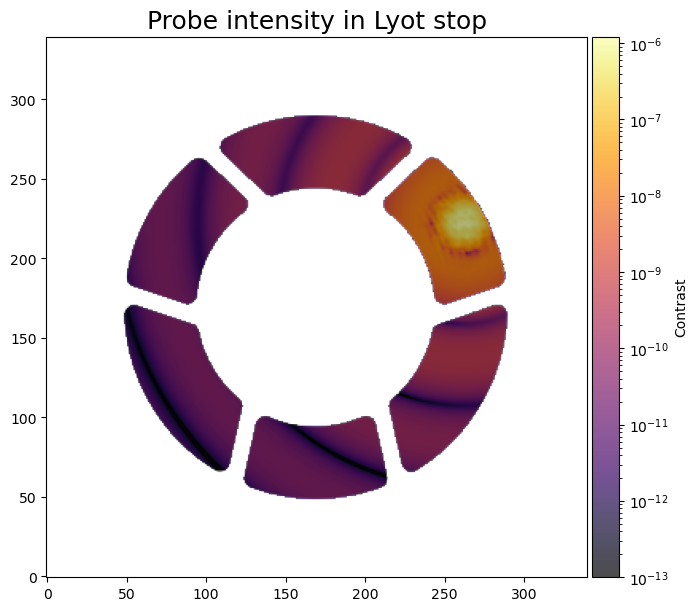

In [32]:
# Wavelenght 0 for e.g.
sl = cfg.sl_list[0]

lyot_mask_fits = np.abs(sl.lyot.e) # Amplitude transmission

# Propagation
dmlist_ref = [dm1_flat, dm2_flat] # Flat DMs from Cell 2
edm0_ref = sl.eprop(dmlist_ref)
E_lyot_ref = sl.proptolyot(edm0_ref)
I_ref = np.abs(E_lyot_ref)**2  # Intensity of starlight

# Probe e_field
edm0_probe = sl.eprop(dmlist_probe)
E_lyot_total = sl.proptolyot(edm0_probe)

# Delta_E to isolate probe impact
Delta_E = E_lyot_total - E_lyot_ref
I_probe = np.abs(Delta_E)**2
I_probe = np.fliplr(I_probe)
I_probe = np.rot90(I_probe, k=3)

# Plotting
def add_colorbar(ax, im, label):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax)
    cbar.set_label(label)

    return cbar

fig, ax = plt.subplots(figsize=(8, 6), constrained_layout=True)

# E_field probe > I

vmin_probe = max(1e-13, I_probe.max() * 1e-8)
vmax_probe = I_probe.max()

# Plotting
ax.set_title(r"Probe intensity in Lyot stop",  fontsize = 18)

# Display
lyot_mask_fits = np.fliplr(lyot_mask_fits)
lyot_mask_fits = np.rot90(lyot_mask_fits, k=3)

ax.imshow(lyot_mask_fits, origin='lower', cmap='gray_r', alpha=1.0) # gray_r so mask is dark

if vmax_probe > 0:
    # Mask low values for cleaner overlay
    probe_masked = np.ma.masked_where(I_probe < vmin_probe, I_probe)

    im3 = ax.imshow(probe_masked, origin='lower', cmap='inferno',
                         norm=LogNorm(vmin=vmin_probe, vmax=vmax_probe), alpha=0.7)
    add_colorbar(ax, im3, "Contrast")

# Save and Show
plt.savefig("test_lyot_compact_model.png", dpi=300)
plt.show()

# SECOND : FULL MODEL
### Remove the FPM convolution for visibility

In [33]:
# Imports
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import yaml
import proper # Required for manual propagation
import corgihowfsc
from corgihowfsc.utils.corgisim_manager import CorgisimManager
from howfsc.model.mode import CoronagraphMode
from howfsc.control.cs import ControlStrategy
from howfsc.util.loadyaml import loadyaml
from matplotlib.lines import Line2D
import roman_preflight_proper
if not os.path.exists('roman_preflight.py'):
    roman_preflight_proper.copy_here()

In [34]:
# Configs of paths

repo_root = os.path.dirname(os.path.abspath(corgihowfsc.__file__))
model_root = os.path.join(repo_root, "model")
nfov_dir = os.path.join(model_root, "nfov_band1", "nfov_band1_360deg")
probes_dir = os.path.join(model_root, "probes")

# Config files
yaml_file = os.path.join(nfov_dir, "howfsc_optical_model.yaml")
hconf_file = os.path.join(model_root, "nfov_band1", "hconf_nfov_flat.yaml")
cstrat_file = os.path.join(nfov_dir, "cstrat_nfov_band1.yaml")

# Probe file to analyze
probe_filename = 'nfov_dm_dmrel_4_1.0e-05_gaussian2.fits'
probe_file = os.path.join(probes_dir, probe_filename)
print(model_root)

C:\Users\ldelaye\Documents\Repos\corgihowfsc\corgihowfsc\model


## Load the entire optical prescription for the Roman telescope (pupil, mirrors, DMs, FPM) with the FULL MODEL
#### Notice : Using is_noise_free: True is perfect. For this diagnosis, we want to see the pure physics of diffraction, without photon or readout noise that would cloud the analysis.

In [35]:
# Inits
cfg = CoronagraphMode(yaml_file)
cstrat = ControlStrategy(cstrat_file)
hconf = loadyaml(hconf_file, custom_exception=TypeError)

# Initialize CorgisimManager (The Full Optical Model wrapper)
overrides = {
    'bandpass': '1',
    'is_noise_free': True,
    'output_dim': 153
}
manager = CorgisimManager(cfg, cstrat, hconf, cor='nfov_flat', corgi_overrides=overrides)

Adding 0 off-axis sources


In [36]:
probe_map = fits.getdata(probe_file)

# My DM commands
# dm1_probe = Flat map + Probe perturbation
dm1_flat = np.zeros(probe_map.shape)
dm1_probe = dm1_flat + probe_map
dm2_flat = np.zeros(probe_map.shape)

## Instead of letting the simulator go all the way to the detector (which is what get_image does by default), we want to force the propagation engine (PROPER) to stop immediately after the Lyot Stop plane via the end_at_lyot_stop flag.
#### Notice : I calculate the total field with the probe, and subtract the reference field (without probe) to see only the effect off the probes.

In [37]:
#  My propagation to Lyot functions
def get_lyot_plane_field(mgr, dm1_v, dm2_v, end_plane_to_simulate='end_at_fpm_exit_pupil'):

    # Create corgi object
    optics = mgr.create_optics(dm1_v, dm2_v, lind=0)

    # Retrieve the good keyword to stop at Lyot stop
    passvalue = optics.optics_keywords.copy()
    passvalue[end_plane_to_simulate] = 1
    passvalue['use_lyot_stop'] = 1
    passvalue['use_fpm'] = 0

    # Run PROPER
    (fields, sampling) = proper.prop_run_multi(
        'roman_preflight',
        optics.lam_um,
        1024, # Grid size (Pupil usually ~1000 pix)
        PASSVALUE=passvalue,
        QUIET=True
    )

    return fields[0]



### You must write two lines in the 'roman_preflight.py' that you just copied in your working directory (from first block when you import it).
### You need to modify it by adding the following 2 lines after the line 1104 where proper.prop_multiply( wavefront, lyot ) is called :
----------------------------------
##### from astropy.io import fits
##### fits.writeto("Lyot_proper_sampling.fits", np.abs(lyot), overwrite=True)
----------------------------------

Then, run the following bloc :

In [38]:
# This image is not relevant : just here to retrieve the Lyot stop (do it one time and it's fine).
Image = get_lyot_plane_field(manager, dm1_flat, dm2_flat, end_plane_to_simulate='end_at_exit_pupil')

E_ref = get_lyot_plane_field(manager, dm1_flat, dm2_flat)
E_probe = get_lyot_plane_field(manager, dm1_probe, dm2_flat)

# Differential field (The E-field added by the probe)
Delta_E = E_probe - E_ref

CorgiOptics initialized with proper keywords.
CorgiOptics initialized with proper keywords.
CorgiOptics initialized with proper keywords.


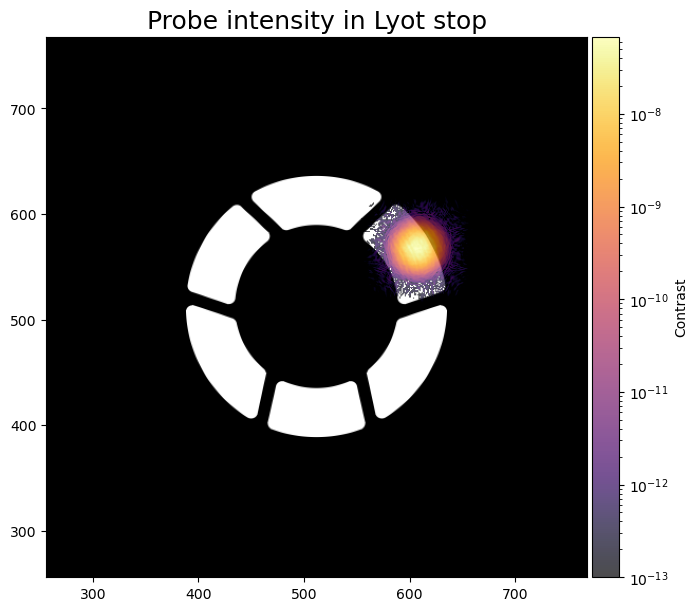

In [40]:
# Load Data
with open(yaml_file, 'r') as f:
    raw_cfg = yaml.safe_load(f)

lyot_mask_fits = fits.getdata("Lyot_proper_sampling.fits")

# Helper for colorbars
def add_colorbar(ax, im, label):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax)
    cbar.set_label(label)
    return cbar

fig, ax = plt.subplots(figsize=(10, 6), constrained_layout=True)

# Define vmin/vmax to prevent LogNorm(0) errors
data_probe = np.abs(Delta_E)**2
vmax_probe = data_probe.max()
vmin_probe = max(1e-13, vmax_probe * 1e-8)

# --- Plot : Lyot Stop ---

ax.set_title(r"Probe intensity in Lyot stop", fontsize = 18)

# Mask
ax.imshow(lyot_mask_fits, origin='lower', cmap='gray', alpha=1.0)

# Overlay
if vmax_probe > vmin_probe:
    probe_masked = np.ma.masked_where(data_probe < vmin_probe, data_probe)

    # Heatmap with transparency
    im3 = ax.imshow(probe_masked, origin='lower', cmap='inferno',
                    norm=LogNorm(vmin=vmin_probe, vmax=vmax_probe), alpha=0.7)

    # Add Colorbar for the probe intensity
    add_colorbar(ax, im3, "Contrast")

# Zoom in (Central crop)
ny, nx = lyot_mask_fits.shape
zoom_fraction = 0.25 # Change it if you want
ax.set_xlim(nx * zoom_fraction, nx * (1 - zoom_fraction))
ax.set_ylim(ny * zoom_fraction, ny * (1 - zoom_fraction))

plt.savefig("test_lyot", dpi = 300)